# Lens Modeling for DESIJ1421-0022

Author : Masuk, Fahim  


In [ ]:
!pip install emcee
!pip install corner
!pip install cobaya
!pip install lenstronomy
!pip install ruff

import yaml
import corner
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util.param_util import ellipticity2phi_q



%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 907.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.0/440.0 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.0/826.0 kB 8.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.6 MB/s eta 0:00:00
  Created wheel for cobaya: filename=cobaya-3.4.1-py3-none-any.whl size=494007 sha256=2cec05af816331de567853b406e47729559fbe90345c99b020924a1eaab174c7
  Stored in directory: /root/.cache/pip/wheels/0c/83/0d/58fe2b1a72c380a15748f87392e1d40b199acb79d0d7b570bc
  Created wheel for GetDist: filename=getdist-1.4.6-py3-non

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 15.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


## Load imaging and psf data

In [ ]:
with h5py.File("DESIJ1421-0022_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]


# load HDF5 psf file using h5py
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"


kwargs_data

{'background_rms': 0.016322818764336215,
 'dec_at_xy_0': -5.639999999999994,
 'exposure_time': array([[392.5919 , 429.8496 , 477.49698, ..., 417.0545 , 626.3687 ,
         470.51013],
        [537.5037 , 481.4545 , 402.75043, ..., 445.28027, 411.41382,
         414.60626],
        [441.50906, 430.91473, 528.3243 , ..., 582.93396, 452.38983,
         456.0343 ],
        ...,
        [455.4104 , 487.22336, 492.4171 , ..., 564.8773 , 450.29538,
         395.7962 ],
        [509.2898 , 384.29117, 459.5256 , ..., 396.0305 , 487.2688 ,
         570.89014],
        [438.19513, 478.61502, 508.9901 , ..., 350.71753, 400.08707,
         430.7757 ]], dtype=float32),
 'image_data': array([[-0.00921469, -0.02078328,  0.00167325, ..., -0.0132964 ,
         -0.03175444, -0.01695797],
        [-0.00559985, -0.01327114, -0.00524183, ...,  0.00243682,
         -0.00851916, -0.01378721],
        [ 0.00427728, -0.00057159, -0.02292269, ..., -0.01166504,
         -0.00735005, -0.00661949],
        ...,
   

In [ ]:
image_size = kwargs_data["image_data"].shape
print(image_size)

(140, 140)


<ipython-input-4-f44519a307c8>:8: RuntimeWarning: invalid value encountered in log10
  axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
<ipython-input-4-f44519a307c8>:11: RuntimeWarning: invalid value encountered in log10
  axes[1].imshow(np.log10(image), origin="lower", cmap="cubehelix")


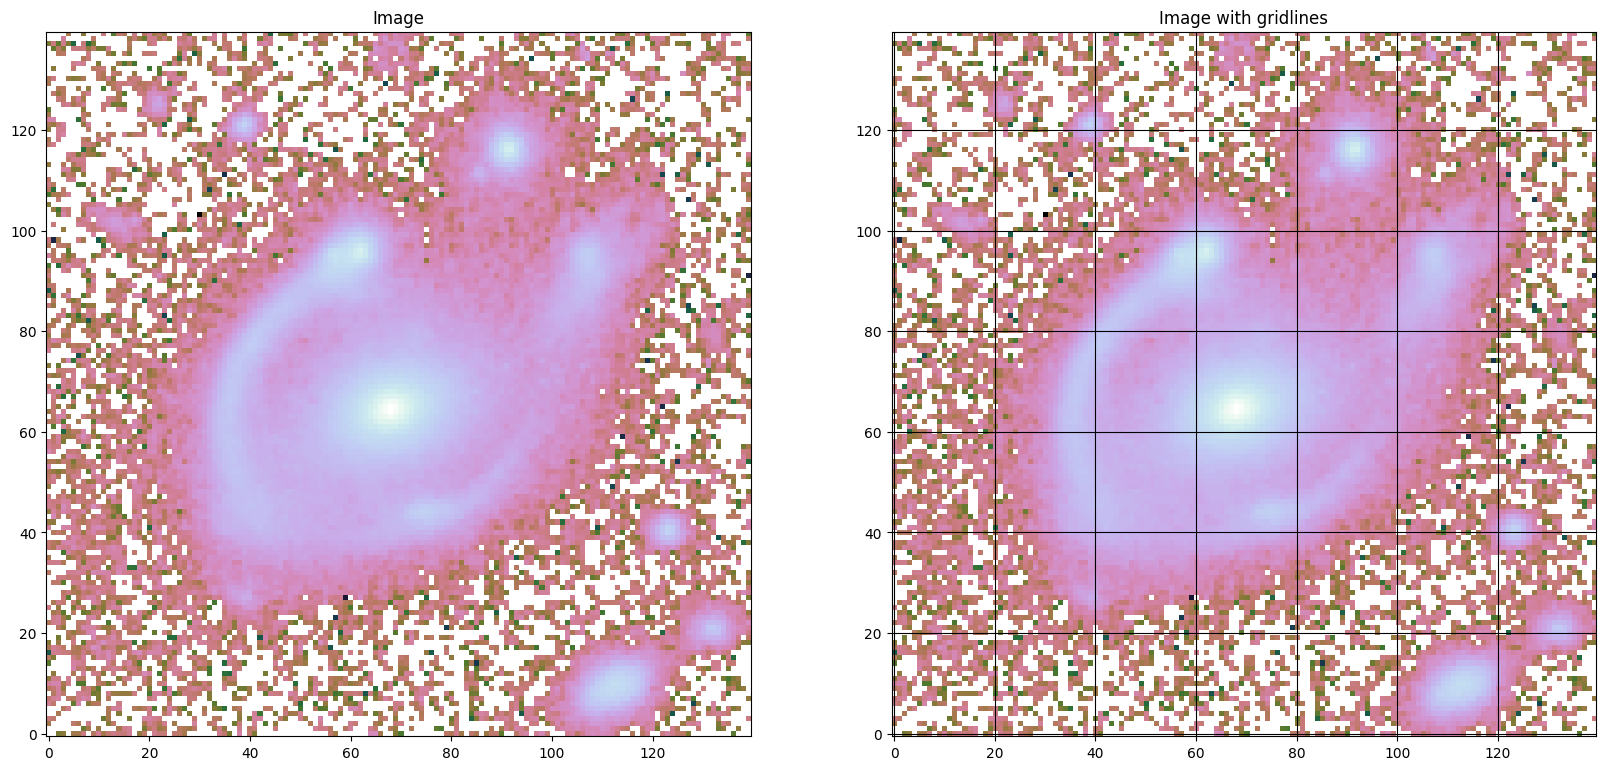

In [ ]:
# extracting image_data from kwargs_data

image = kwargs_data["image_data"]

# Make the plot
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[0].set_title("Image")

axes[1].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[1].set_title("Image with gridlines")
axes[1].grid(True, color="black")

# Show the plots
plt.show()

## Masking

In [ ]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])


x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

lens_center_ra = 0
lens_center_dec = 0


mask_outer = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra,
    lens_center_dec,
    4.8,
    3.6,
    -np.pi / 4,
)

# 11 o' clock

mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.8,
    lens_center_dec + 2,
    0.7,
    0.7,
    -np.pi / 6,
)


# 1 o' clock
mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 1.6,
    lens_center_dec + 3.6,
    0.8,
    0.7,
    -np.pi / 6,
)


mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.9,
    lens_center_dec + 1.8,
    1.5,
    1,
    -np.pi / 3,
)

# 5 o' clock

mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.5,
    lens_center_dec - 2.1,
    1.0,
    0.5,
    -np.pi / 6,
)

# 7 o' clock
mask_ext_5 = mask_util.mask_center_2d(
    lens_center_ra + 2.5,
    lens_center_dec - 3.4,
    0.4,
    util.image2array(x_coords),
    util.image2array(y_coords),
)

# 8 o' clock
mask_ext_6 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra+2.9,
    lens_center_dec-2.2,
    0.5,
    0.3,
    np.pi/3
)

mask = (mask_outer
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_6))

mask[mask >= 1] = 1
mask[mask < 0] = 0

mask_img_1 = mask.reshape(num_pix, num_pix)



<ipython-input-8-4d2b903b9439>:3: RuntimeWarning: invalid value encountered in log10
  axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
<ipython-input-8-4d2b903b9439>:13: RuntimeWarning: divide by zero encountered in log10
  image_after_mask = np.log10(image * mask)
<ipython-input-8-4d2b903b9439>:13: RuntimeWarning: invalid value encountered in log10
  image_after_mask = np.log10(image * mask)


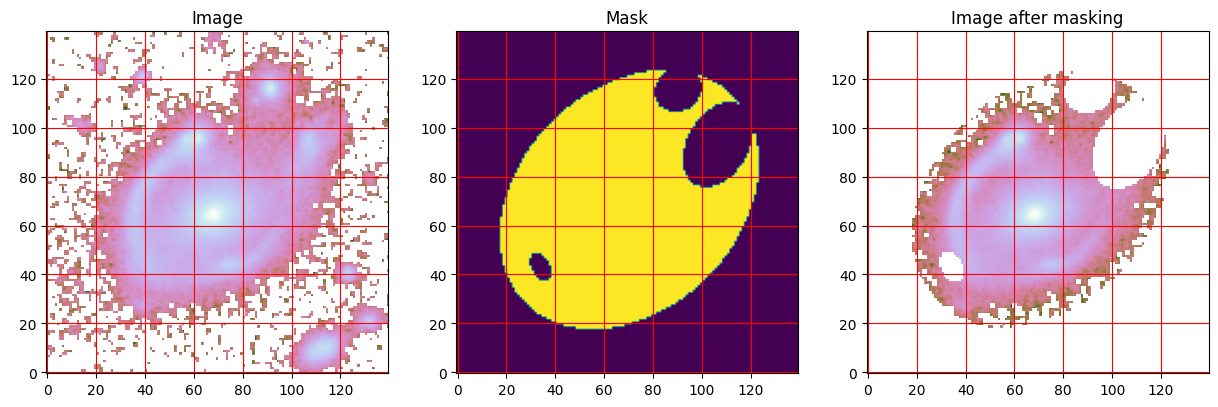

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[0].grid(True, color="red")
axes[0].set_title("Image")

mask = mask.reshape(num_pix, num_pix)

axes[1].imshow(mask, origin="lower")
axes[1].grid(True, color="red")
axes[1].set_title("Mask")

image_after_mask = np.log10(image * mask)

axes[2].imshow(image_after_mask, origin="lower", cmap="cubehelix")
axes[2].grid(True, color="red")
axes[2].set_title("Image after masking")
# Show the plots
plt.show()

## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. We checked [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{qx^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

In [ ]:
lens_model_list = ["EPL", "SHEAR", "FLEXION"] #
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

### Lens galaxy's mass model

In [ ]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# setting EPL parameters

fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 4.5,
        "gamma": 1.85,
        "e1":  0.119,
        "e2":  -0.204,
        "center_x":  0.232,
        "center_y":  -0.426,
    }
)

kwargs_lens_sigma.append(
    {
        "theta_E": 0.5,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 2.5,
        "gamma": 1.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 6,
        "gamma": 2.4,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)


# Setting SHEAR Parameters
fixed_lens.append({"ra_0": 0, "dec_0": 0})

kwargs_lens_init.append({"gamma1": 0.12, "gamma2": -0.29, "ra_0": 0, "dec_0": 0})
kwargs_lens_sigma.append({"gamma1": 0.1, "gamma2": 0.1, "ra_0": 0, "dec_0": 0})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3, "ra_0": -100, "dec_0": -100})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3, "ra_0": 100, "dec_0": 100})

# FLEXION

fixed_lens.append({"ra_0": 0.0, "dec_0": 0.0})

kwargs_lens_init.append(
    {"g1": -0.069, "g2": 0.051, "g3": -0.0929, "g4":  0.0345, "ra_0": 0.0, "dec_0": 0.0920}
)
kwargs_lens_sigma.append(
    {"g1": 0.01, "g2": 0.01, "g3": 0.01, "g4": 0.01, "ra_0": 0.0, "dec_0": 0.0}
)
kwargs_lower_lens.append(
    {"g1": -0.1, "g2": -0.1, "g3": -0.1, "g4": -0.1, "ra_0": 0.0, "dec_0": 0.0}
)
kwargs_upper_lens.append(
    {"g1": 0.1, "g2": 0.1, "g3": 0.1, "g4": 0.1, "ra_0": 0.0, "dec_0": 0.0}
)


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

### Lens galaxy's light model

In [ ]:
# lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

# 1st sersic

fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "R_sersic":  0.33,
        "n_sersic": 2,
        "e1": 0.060,
        "e2": -0.075,
        "center_x": 0.1854,
        "center_y":  -0.4809,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.01,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 2,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# 2nd sersic

fixed_lens_light.append({"n_sersic": 1.0})
kwargs_lens_light_init.append(
    {
        "amp": 16,
        "R_sersic":   5,
        "n_sersic": 2,
        "e1": 0.06,
        "e2": -0.075,
        "center_x":  0.185,
        "center_y":  -0.480,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.5,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 5,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y", "e1", "e2"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

### Source galaxy's light model

In [ ]:
# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


# setting SERSIC_ELLIPSE parameters
fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.09,
        "n_sersic": 0.6,
        "e1":  -0.44,
        "e2": 0.199,
        "center_x": -0.18,
        "center_y": -1.186,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.05,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.15,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


# setting SHAPELETS parameters
fixed_source.append({"n_max": 10})
kwargs_source_init.append({"beta": 0.4, "center_x": -0.180, "center_y": -1.18})
kwargs_source_sigma.append({"beta": 0.1, "center_x": 0.2, "center_y": 0.2})
kwargs_lower_source.append({"beta": 0.01, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 0.5, "center_x": 10, "center_y": 10})


joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]

joint_lens_with_light = [[0, 0, ["center_x", "center_y", "e1", "e2"]]]


source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

### Combining all the above specification in the `kwargs_params` dictionary

In [ ]:
# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_source_with_source,
    #"joint_lens_with_light": joint_lens_with_light
}


In [ ]:
def custom_log_likelihood_addition(
    kwargs_lens=None,
    kwargs_source=None,
    kwargs_lens_light=None,
    kwargs_ps=None,
    kwargs_special=None,
    kwargs_extinction=None,
):
    """

    :param kwargs_lens: lens mass model keywords

    :type kwargs_lens: list

    :param kwargs_source: source light model keywords

    :type kwargs_source: list

    :param kwargs_lens_light: lens light model keywords

    :type kwargs_lens_light:  list

    :param kwargs_ps: point source keywords

    :type kwargs_ps: list

    :param kwargs_special: special keywords

    :type kwargs_special: list

    :param kwargs_extinction: extinction model keywords

    :type kwargs_extinction: list

    :return: custom log_likelihood

    :rtype: float

    """

    log_likelihood = 0.0

    mass_phi, mass_q = ellipticity2phi_q(kwargs_lens[0]["e1"], kwargs_lens[0]["e2"])
    light_phi, light_q = ellipticity2phi_q(
        kwargs_lens_light[0]["e1"], kwargs_lens_light[0]["e2"]
    )

    gaussian_std = 0.01
    if mass_q < light_q:
        log_likelihood += -0.5 * (mass_q - light_q) ** 2 / gaussian_std**2

    return log_likelihood

### Numerical settings

In [ ]:
kwargs_likelihood = {"custom_logL_addition": custom_log_likelihood_addition,
    "check_bounds": True, "image_likelihood_mask_list": [mask_img_1]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

### Combining all the information to be sent to lenstronomy

In [ ]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

## Here the model fitting is done

In [ ]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 150, "n_iterations": 100}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-2.7714657268985166 reduced X^2 of best position
-10150.493224765816 log likelihood
7325 effective number of data points
[{'theta_E': 4.371726994097673, 'gamma': 1.8331622100422307, 'e1': 0.12142943627587606, 'e2': -0.19210133805267313, 'center_x': -0.014040420295952103, 'center_y': -0.47556834374296103}, {'gamma1': 0.13984104977376308, 'gamma2': -0.29391098780711455, 'ra_0': 0, 'dec_0': 0}, {'g1': -0.0998317754292202, 'g2': 0.049634904866051835, 'g3': -0.07009304281817723, 'g4': 0.022855719829478524, 'ra_0': 0.0, 'dec_0': 0.0}] lens result
[{'amp': 1, 'R_sersic': 0.05054627327136339, 'n_sersic': 1.0, 'e1': -0.30565495414683286, 'e2': 0.21085754946823118, 'center_x': -0.14472847581335388, 'center_y': -1.5226568857040046}, {'amp': 1, 'n_max': 10, 'beta': 0.4601983442410391, 'center_x': -0.14472847581335388, 'center_y': -1.5226568857040046}] source result
[{'amp': 1, 'R_sersic': 0.37247313889471395, 'n_

-2.721565426205563 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  2.7215654262055518


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: invalid value encountered in log10
  np.log10(self._model),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:286: RuntimeWarning: invalid value encountered in log10
  np.log10(kappa_result),
<ipython-input-21-365574458a8f>:21: UserWa

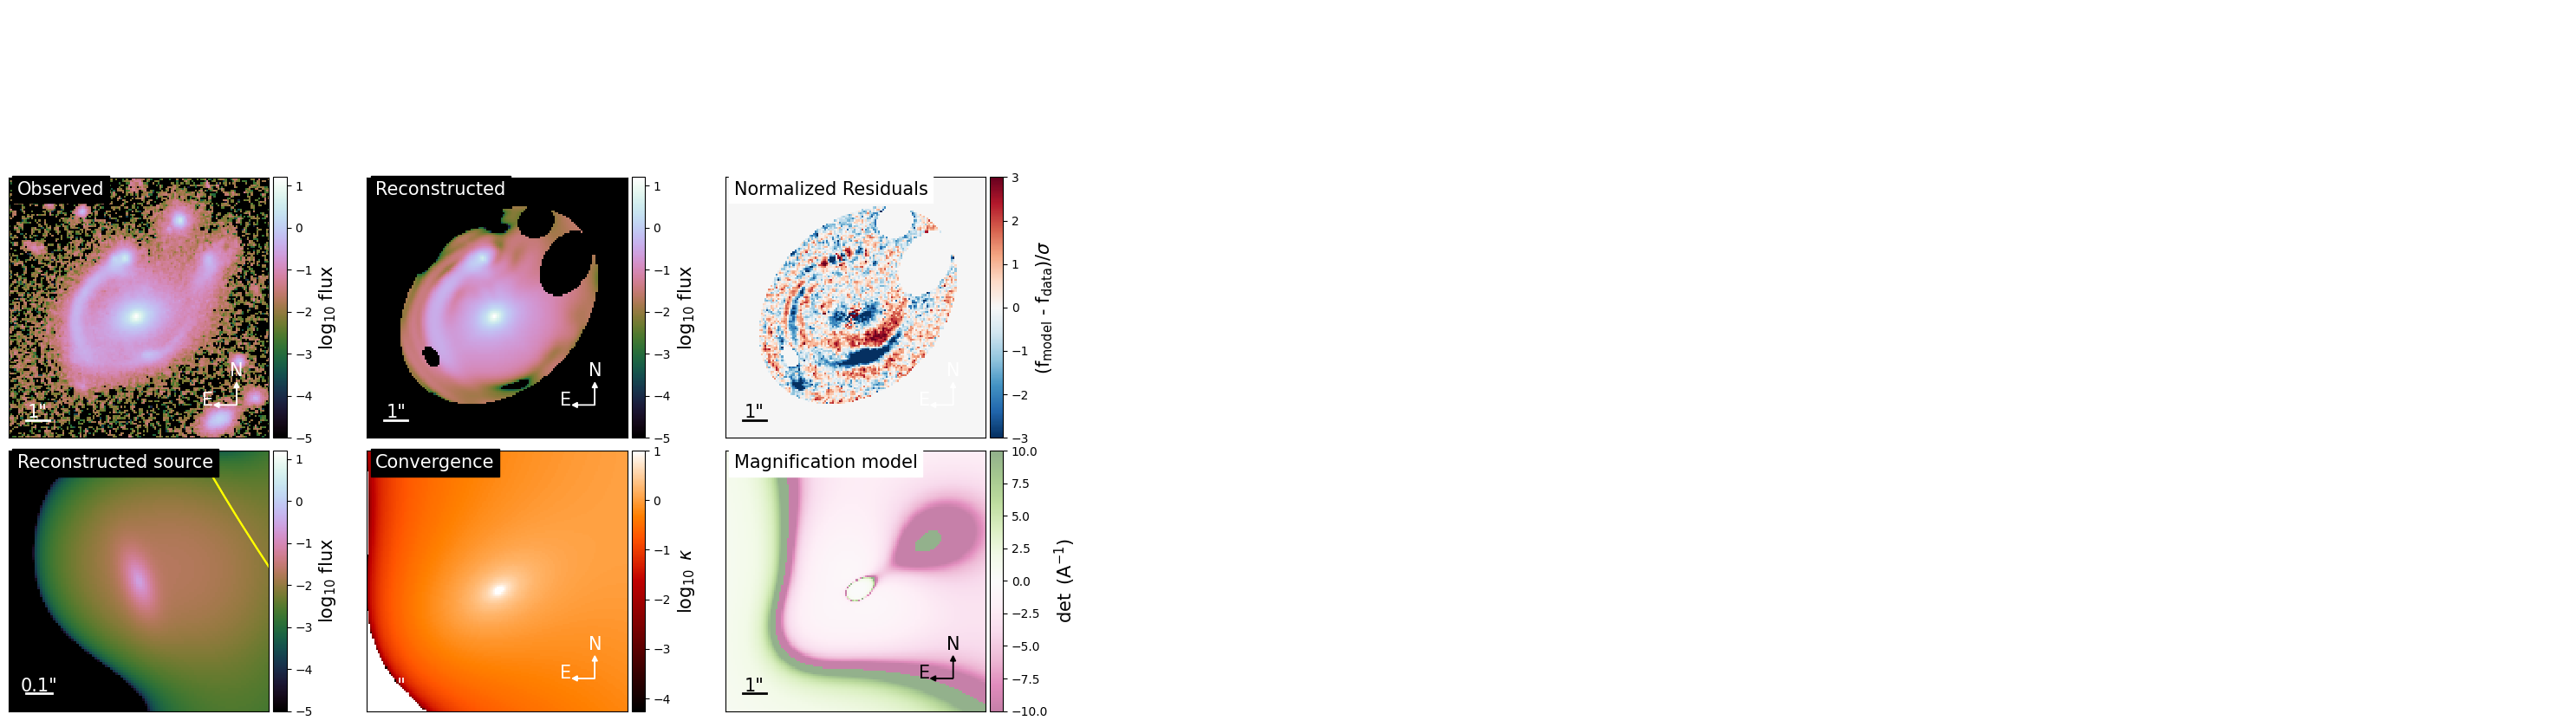

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


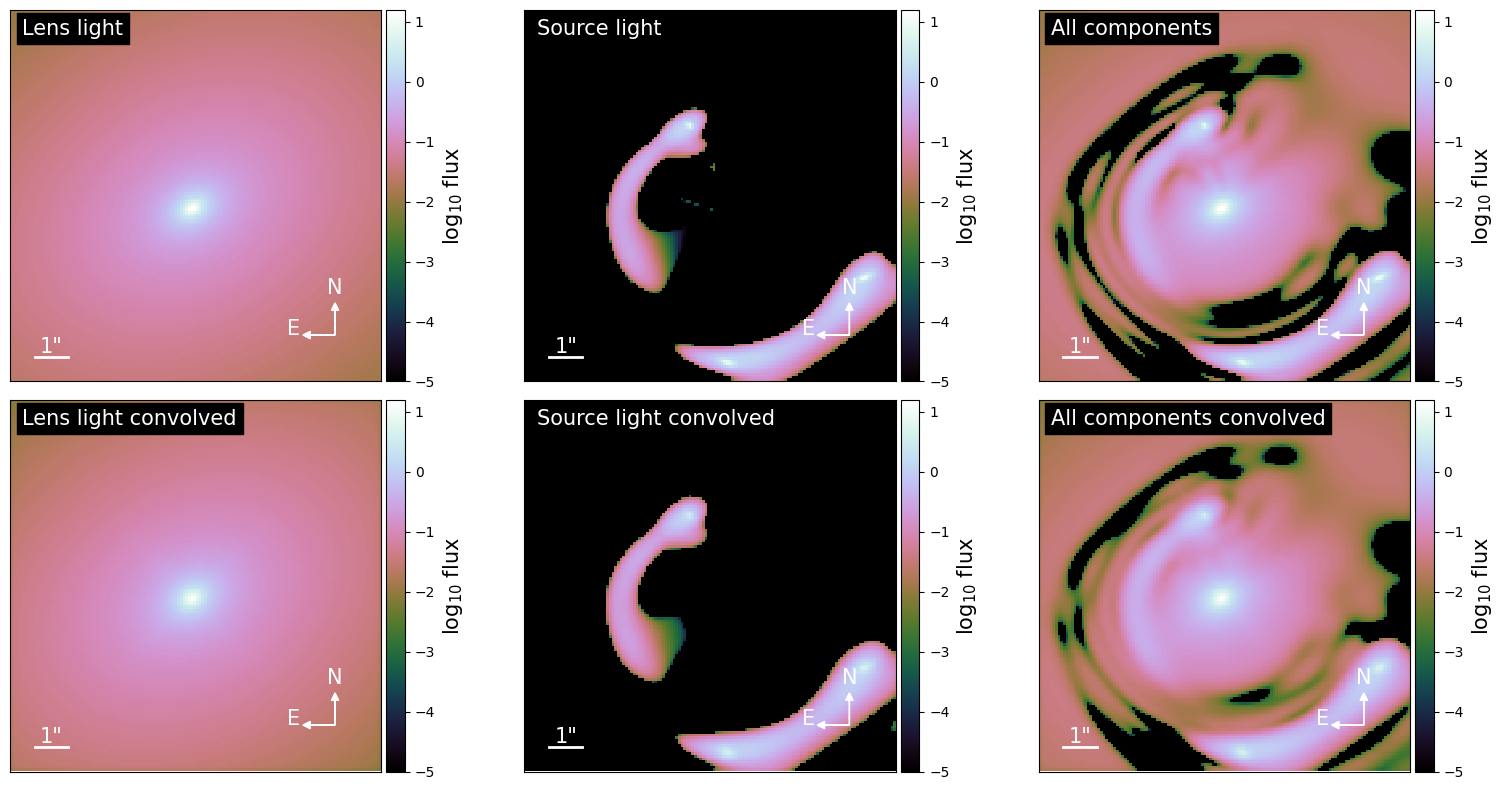

{'kwargs_lens': [{'theta_E': 4.371726994097673, 'gamma': 1.8331622100422307, 'e1': 0.12142943627587606, 'e2': -0.19210133805267313, 'center_x': -0.014040420295952103, 'center_y': -0.47556834374296103}, {'gamma1': 0.13984104977376308, 'gamma2': -0.29391098780711455, 'ra_0': 0, 'dec_0': 0}, {'g1': -0.0998317754292202, 'g2': 0.049634904866051835, 'g3': -0.07009304281817723, 'g4': 0.022855719829478524, 'ra_0': 0.0, 'dec_0': 0.0}], 'kwargs_source': [{'amp': 544.5391703476971, 'R_sersic': 0.05054627327136339, 'n_sersic': 1.0, 'e1': -0.30565495414683286, 'e2': 0.21085754946823118, 'center_x': -0.14472847581335388, 'center_y': -1.5226568857040046}, {'amp': array([ 1.25922468e+02, -8.41894258e+01,  1.84520271e+01, -3.90031269e+01,
       -1.47387765e+01, -7.27034369e+01,  1.50953388e+01,  2.47735332e+01,
       -9.36985958e-01, -1.19503272e+01,  3.62080546e-01, -3.26875875e+01,
        2.97388034e+01, -1.09742402e+01,  1.99430499e+01, -4.40314592e+00,
        2.24777030e+01, -4.31418477e+01,  2

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.01, numPix=100, with_caustics=True
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)

## Visualizing the fitted model

-1.7416030251366001 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.741603025136597


<ipython-input-60-365574458a8f>:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


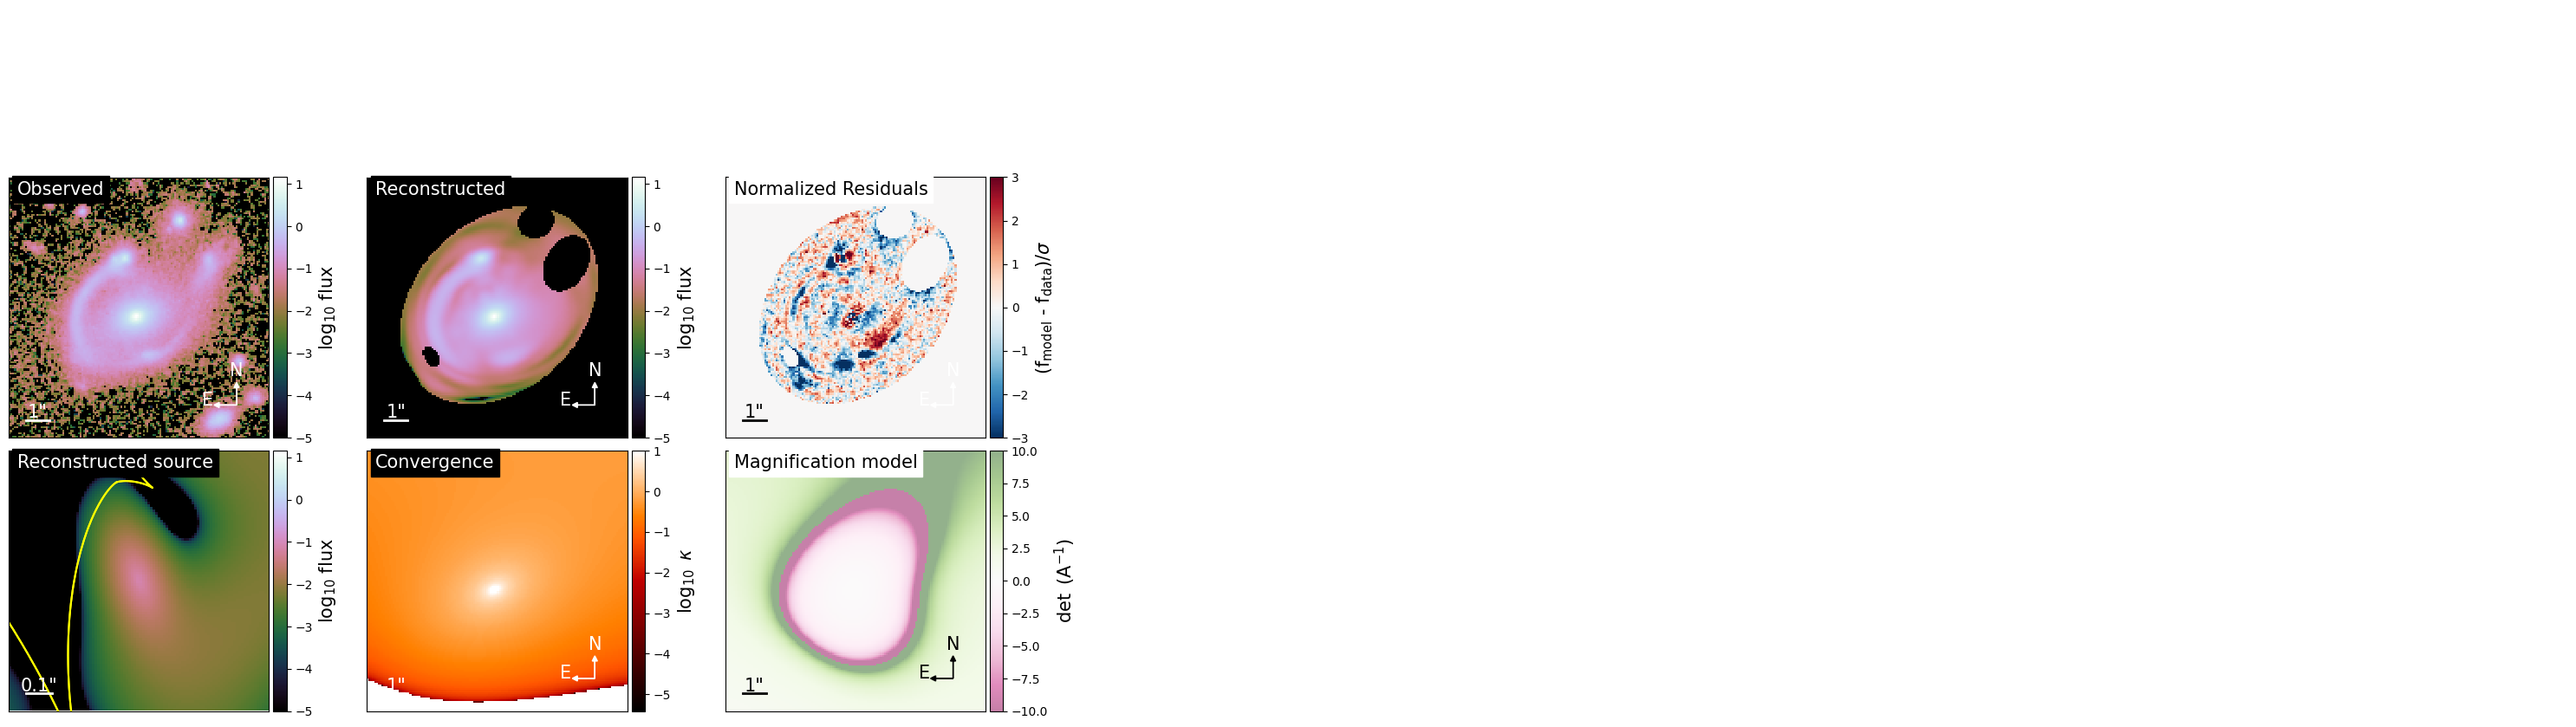

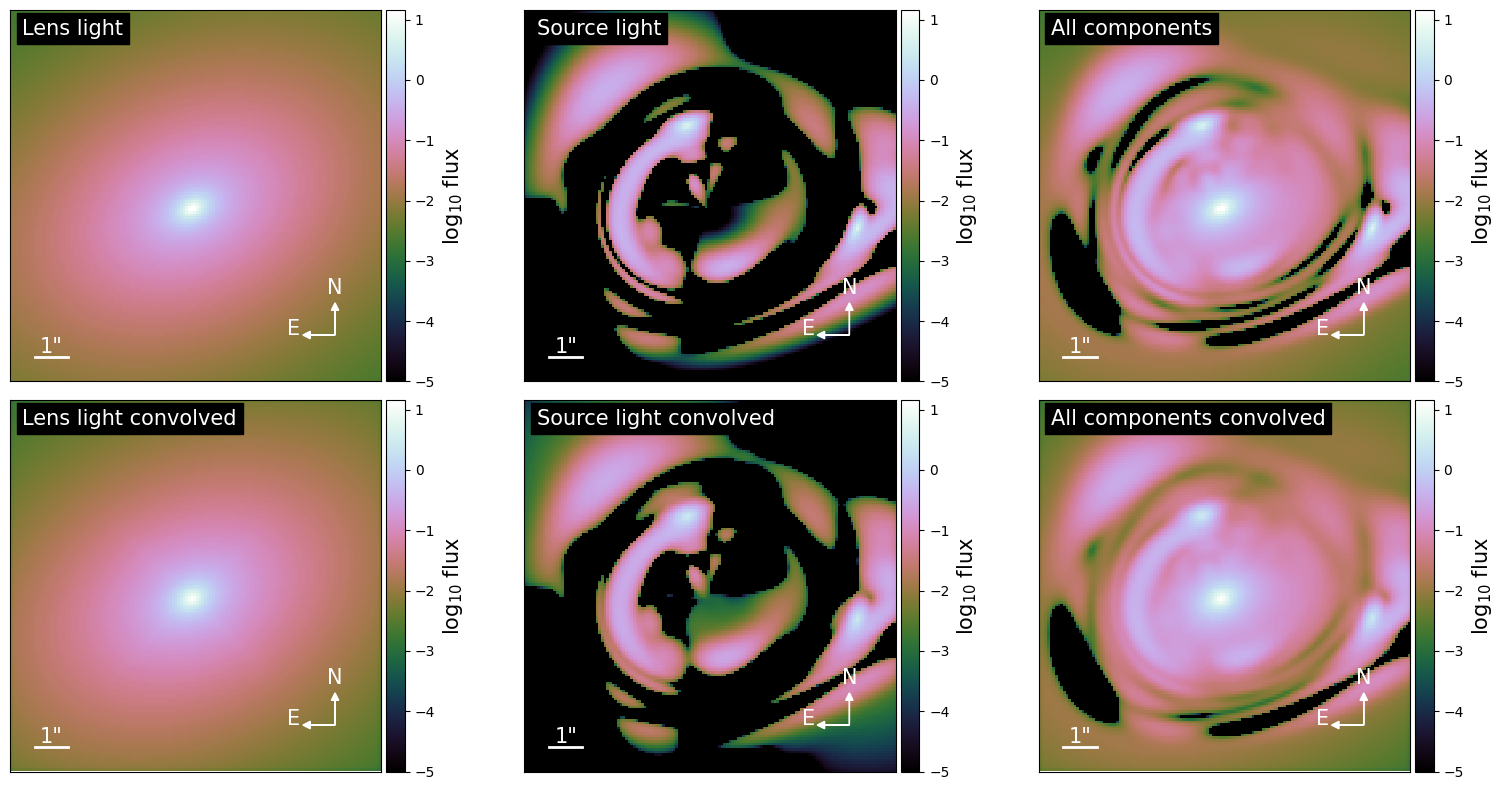

{'kwargs_lens': [{'theta_E': 3.321729243277242, 'gamma': 2, 'e1': 0.11389089438923586, 'e2': -0.14130621354055542, 'center_x': 0.19239688078978961, 'center_y': -0.4843624435943957}, {'gamma1': 0.18063159196934536, 'gamma2': -0.07021005380982438, 'ra_0': 0, 'dec_0': 0}, {'g1': -0.04124846013500922, 'g2': 0.021010825103173373, 'g3': 0.02350427041590757, 'g4': 0.09203133057954636, 'ra_0': 0.0, 'dec_0': 0.0}], 'kwargs_source': [{'amp': 160.79876906850095, 'R_sersic': 0.12382672084611449, 'n_sersic': 1.0, 'e1': -0.2878512748510012, 'e2': 0.20160192272164154, 'center_x': -0.22610574923577545, 'center_y': -1.143956066486664}, {'amp': array([ 41.53034325, -59.93155728,  -1.98945443,  11.24235317,
       -16.72991523,  16.68731499,  22.03285489,  29.92619113,
        -2.82066982,  28.6140865 , -33.57873031,  -2.98677893,
        -6.04066909,  -0.56216694,   2.14693758,  -4.24679652,
         0.68763313,  14.05541262,   6.49139269,  11.91609782,
         1.38524481,   2.73724959,  14.24379252,  

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.01, numPix=100, with_caustics=True
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)